# COCoNIC
This notebook converts the `CoNIC` dataset format into `COCO` format, as specified [here](https://cocodataset.org/#format-data).

In [16]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import cv2
import json
import imageio

from pathlib import Path
from typing import Dict
from tqdm.notebook import tqdm


mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

In [10]:
def save_json(d: Dict, file: str):
  file = Path(file)
  file.parents[0].mkdir(exist_ok=True, parents=True)
  with open(file, 'w') as f:
    json.dump(d, f)

In [2]:
# Random seed for deterministic
SEED = 5
# The number of nuclei within the dataset/predictions.
# For CoNIC, we have 6 (+1 for background) types in total.
NUM_TYPES = 7

data_root = "../dataset" # path to dataset folder
OUT_DIR = "output"

images_path = f"{data_root}/images.npy" # images array Nx256x256x3
labels_path = f"{data_root}/labels.npy" # labels array Nx256x256x3
counts_path = f"{data_root}/counts.csv" # csv of counts per nuclear type for each patch
info_path = f"{data_root}/patch_info.csv" # csv indicating which image from Lizard each patch comes from

In [4]:
images = np.load(images_path)
labels = np.load(labels_path)
counts = pd.read_csv(counts_path)
patch_info = pd.read_csv(info_path)

# Basic COCO Info
First, let's create an image folder where all the images are in `.png` format.

In [5]:
coco_dataset = {
    'info': {
        'description': 'Patch-level LIZARD dataset for CoNIC Challenge',
        'url': 'https://www.kaggle.com/aadimator/conic-challenge-dataset',
        "version": "1.0",
        "year": 2021,
        "contributor": "Simon Graham et al.",
        "date_created": "2021-11-27"
    },
    "licenses": [
        {
          "url": "https://creativecommons.org/licenses/by-nc-sa/4.0/",
          "id": 1,
          "name": "Attribution-NonCommercial-ShareAlike 4.0 International License"
        }
    ]
}

coco_dataset

{'info': {'description': 'Patch-level LIZARD dataset for CoNIC Challenge',
  'url': 'https://www.kaggle.com/aadimator/conic-challenge-dataset',
  'version': '1.0',
  'year': 2021,
  'contributor': 'Simon Graham et al.',
  'date_created': '2021-11-27'},
 'licenses': [{'url': 'https://creativecommons.org/licenses/by-nc-sa/4.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-ShareAlike 4.0 International License'}]}

In [6]:
categories = ['background', 'neutrophil', 'epithelial', 'lymphocyte', 'plasma', 'eosinophil', 'connective']
colors = {
    categories[0]: [0, 0, 0],
    categories[1]: [255, 0, 0],
    categories[2]: [0, 255, 0],
    categories[3]: [0, 0, 255],
    categories[4]: [255, 255, 0],
    categories[5]: [255, 0, 255],
    categories[6]: [0, 255, 255]
}
cats = [{'name':name, 'id':id+1, 'isthing': 1, 'color': colors[name]} for id,name in enumerate(categories[1:])]
cats.insert(0, {'name': 'background', 'id': 0, 'isthing': 0, 'color': colors[categories[0]]})
coco_dataset['categories'] = cats
coco_dataset

{'info': {'description': 'Patch-level LIZARD dataset for CoNIC Challenge',
  'url': 'https://www.kaggle.com/aadimator/conic-challenge-dataset',
  'version': '1.0',
  'year': 2021,
  'contributor': 'Simon Graham et al.',
  'date_created': '2021-11-27'},
 'licenses': [{'url': 'https://creativecommons.org/licenses/by-nc-sa/4.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-ShareAlike 4.0 International License'}],
 'categories': [{'name': 'background',
   'id': 0,
   'isthing': 0,
   'color': [0, 0, 0]},
  {'name': 'neutrophil', 'id': 1, 'isthing': 1, 'color': [255, 0, 0]},
  {'name': 'epithelial', 'id': 2, 'isthing': 1, 'color': [0, 255, 0]},
  {'name': 'lymphocyte', 'id': 3, 'isthing': 1, 'color': [0, 0, 255]},
  {'name': 'plasma', 'id': 4, 'isthing': 1, 'color': [255, 255, 0]},
  {'name': 'eosinophil', 'id': 5, 'isthing': 1, 'color': [255, 0, 255]},
  {'name': 'connective', 'id': 6, 'isthing': 1, 'color': [0, 255, 255]}]}

In [7]:
imgs = [{'id':id, 'width': 256, 'height': 256, 'file_name': f'{id}.png', 'license': 1} for id in patch_info['patch_info']]
coco_dataset['images'] = imgs
# coco_dataset

In [14]:
save_json(coco_dataset, f'{OUT_DIR}/images.json')
save_json(cats, f'{OUT_DIR}/categories.json')

## Create directories
Store images and annotations in the correct format so they can then be processed by the `converter` scripts.

The official scripts expect the 2 channel format to be a `png` file, where the first channel is the **semantic category label** and the second channel is the **instance ID label**. The **CoNIC** annotations have **instance ID label** as the first channel and the **semantic category label** as the second. So we'll have to modify their order as well.

In [3]:
import os
import shutil

def rm_n_mkdir(dir_path):
    """Remove and then make a new directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)
    

images_dir = 'images'
ann_dir = 'annotations_2ch'


In [ ]:

rm_n_mkdir(f'{OUT_DIR}/{images_dir}/')
rm_n_mkdir(f'{OUT_DIR}/{ann_dir}/')
for idx in tqdm(range(images.shape[0])):
    img = images[idx]
    ann = labels[idx, :, :, ::-1].astype('uint8') # change instance and classification map ordering

    # make a 3rd channel, of all zeros so we can save image as `png`
    zeros = np.zeros_like(ann[..., 0])
    ann = cv2.merge((ann, zeros))
    
    imageio.imwrite(f'{OUT_DIR}/{images_dir}/{patch_info.patch_info[idx]}.png', img)
    imageio.imwrite(f'{OUT_DIR}/{ann_dir}/{patch_info.patch_info[idx]}.png', ann)

## Panoptic COCO conversion
The scripts are taken from the official [cocodataset/panopticapi](https://github.com/cocodataset/panopticapi) repository. I have only disabled the parallel processing as this was not working as expected on Windows, and I didn't have much time to debug the issues.

### From 2 Channel Format to Panoptic Format

In [4]:
import converters.two_chan_to_panoptic as two_chan_pan

source_folder = f'{OUT_DIR}/{ann_dir}'
images_json_file = f'{OUT_DIR}/images.json'
categories_json_file = f'{OUT_DIR}/categories.json'
segmentations_folder = f'{OUT_DIR}/panoptic'
predictions_json_file = f'{OUT_DIR}/panoptic.json'

two_chan_pan.converter(source_folder, images_json_file, categories_json_file, segmentations_folder, predictions_json_file)

Reading image set information from output/images.json
CONVERTING...
2 channels panoptic format:
	Source folder: output/annotations_2ch
TO
COCO panoptic format:
	Segmentation folder: output/panoptic
	JSON file: output/panoptic.json


Number of cores: 8, images per core: 623
Core: 0, 0 from 623 images convertedCore: 1, 0 from 623 images converted

Core: 2, 0 from 623 images convertedCore: 3, 0 from 623 images convertedCore: 4, 0 from 623 images convertedCore: 6, 0 from 622 images converted


0: 623
1: 623
2: 623
3: 623
4: 623
5: 622
6: 622
7: 622
Core: 5, 0 from 622 images convertedCore: 7, 0 from 622 images converted


Core: 1, 100 from 623 images converted
Core: 0, 100 from 623 images converted
Core: 2, 100 from 623 images converted
Core: 4, 100 from 623 images converted
Core: 6, 100 from 622 images converted
Core: 3, 100 from 623 images converted
Core: 1, 200 from 623 images converted
Core: 2, 200 from 623 images converted
Core: 7, 100 from 622 images converted
Core: 5, 100 from 622 i

### From Panoptic format to Object Detection format

In [4]:
from converters.panoptic_to_detection import convert_panoptic_to_detection_coco_format

input_json_file = f'{OUT_DIR}/panoptic.json'
segmentations_folder = f'{OUT_DIR}/panoptic'
output_json_file = f'{OUT_DIR}/instances.json'
categories_json_file = f'{OUT_DIR}/categories.json'
things_only = True

convert_panoptic_to_detection_coco_format(input_json_file,
                                          segmentations_folder,
                                          output_json_file,
                                          categories_json_file,
                                          things_only)

CONVERTING...
COCO panoptic format:
	Segmentation folder: output/panoptic
	JSON file: output/panoptic.json
TO
COCO detection format
	JSON file: output/instances.json
Saving only segments of things classes.


Reading annotation information from output/panoptic.json
Number of cores: 8, images per core: 623
Core: 0, 0 from 623 images processed
Core: 1, 0 from 623 images processed
Core: 2, 0 from 623 images processed
Core: 3, 0 from 623 images processed
Core: 4, 0 from 623 images processed
Core: 5, 0 from 622 images processed
Core: 6, 0 from 622 images processed
Core: 7, 0 from 622 images processed
Core: 1, 100 from 623 images processed
Core: 0, 100 from 623 images processed
Core: 2, 100 from 623 images processed
Core: 4, 100 from 623 images processed
Core: 1, 200 from 623 images processed
Core: 3, 100 from 623 images processed
Core: 6, 100 from 622 images processed
Core: 2, 200 from 623 images processed
Core: 0, 200 from 623 images processed
Core: 5, 100 from 622 images processed
Core: 7,

In [4]:
# to prettify the json file
# python -m json.tool .\instance.json > pretty.json

# Visualization

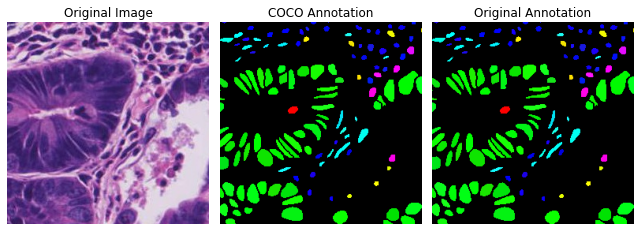

In [8]:
# https://github.com/cocodataset/panopticapi/blob/master/visualization.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import os
import numpy as np
import json

import PIL.Image as Image
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

from converters.utils import IdGenerator, rgb2id

# whether from the PNG are used or new colors are generated
generate_new_colors = False

json_file = f'{OUT_DIR}/panoptic.json'
segmentations_folder = f'{OUT_DIR}/panoptic'
img_folder = f'{OUT_DIR}/{images_dir}'
orig_ann_folder = f'{OUT_DIR}/{ann_dir}'
panoptic_coco_categories = f'{OUT_DIR}/categories.json'

with open(json_file, 'r') as f:
    coco_d = json.load(f)

ann = np.random.choice(coco_d['annotations'])

with open(panoptic_coco_categories, 'r') as f:
    categories_list = json.load(f)
categegories = {category['id']: category for category in categories_list}

# find input img that correspond to the annotation
img = None
for image_info in coco_d['images']:
    if image_info['id'] == ann['image_id']:
        try:
            img = np.array(
                Image.open(os.path.join(img_folder, image_info['file_name']))
            )
            orig_ann = np.array(
                Image.open(os.path.join(orig_ann_folder, image_info['file_name'])))
        except:
            print("Undable to find correspoding input image.")
        break

segmentation = np.array(
    Image.open(os.path.join(segmentations_folder, ann['file_name'])),
    dtype=np.uint8
)
segmentation_id = rgb2id(segmentation)
# find segments boundaries
boundaries = find_boundaries(segmentation_id, mode='thick')

if generate_new_colors:
    segmentation[:, :, :] = 0
    color_generator = IdGenerator(categegories)
    for segment_info in ann['segments_info']:
        color = color_generator.get_color(segment_info['category_id'])
        mask = segmentation_id == segment_info['id']
        segmentation[mask] = color

# depict boundaries
segmentation[boundaries] = [0, 0, 0]

if img is None:
    plt.figure()
    plt.imshow(segmentation)
    plt.axis('off')
else:
    plt.figure(figsize=(9, 5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(132)
    plt.title('COCO Annotation')
    plt.imshow(segmentation)
    plt.axis('off')
    plt.tight_layout()
    plt.subplot(133)
    plt.title('Original Annotation')
    plt.imshow(segmentation)
    plt.axis('off')
    plt.tight_layout()
plt.show()